In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tsfel
from scipy.signal import argrelextrema, find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import math
import json
from sklearn.metrics import mean_squared_error
import pandas as pd
import sys
sys.path.append("../")
from dsp import scg_simulate
from BSG_preprocessing_individual import processs_data_individual

# 用来去除peaks里的错误值
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

# 用来获得信号的峰值点
def get_peaks(signal):
    t = np.arange(len(signal))
    # 峰值检测
    peak_indices, _ = find_peaks(signal)  # 返回极大值点的索引

    # 线性插值
    t_peaks = t[peak_indices]  # 极大值点的时间
    peak_values = signal[peak_indices]  # 极大值点的幅值
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)
    
    # 提取峰值点形成的波的波峰
    peaks2,_ = find_peaks(envelope, distance = 10)

    peaks2 = update_array(peaks2, signal)
    
    if signal[peaks2[0]]>signal[peaks2[1]]:
        peaks2 = np.delete(peaks2, 0)
    
    if len(peaks2)%2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)
    
    return peaks2

def get_peaks_tmp(signal):
    t = np.arange(len(signal))
    # 峰值检测
    peak_indices, _ = find_peaks(signal)  # 返回极大值点的索引

    # 线性插值
    t_peaks = t[peak_indices]  # 极大值点的时间
    peak_values = signal[peak_indices]  # 极大值点的幅值
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)
    
    # 提取峰值点形成的波的波峰
    peaks2,_ = find_peaks(envelope, distance = 10)

    peaks2 = update_array(peaks2, signal)
    
    if signal[peaks2[0]]<signal[peaks2[1]]:
        peaks2 = np.delete(peaks2, 0)
    
    if len(peaks2)%2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)
    
    return peaks2

def get_template_peaks(signal):
    t = np.arange(len(signal))
    # 峰值检测
    peak_indices, _ = find_peaks(signal)  # 返回极大值点的索引

    # 线性插值
    t_peaks = t[peak_indices]  # 极大值点的时间
    peak_values = signal[peak_indices]  # 极大值点的幅值
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)
    
    # 提取峰值点形成的波的波峰
    peaks2,_ = find_peaks(envelope, distance = 10)
    values_at_peaks = signal[peaks2]

    # 找到最高的两个峰值对应的值和下标
    top_two_indices = np.argsort(values_at_peaks)[-2:]  # 取排序后的最后两个值的下标

    # 从 peaks 中取出这两个最高峰值的原始下标
    new_peaks = peaks2[top_two_indices]
    new_peaks = new_peaks[::-1]

    # new_peaks 现在包含 signal 中最高的两个峰值的下标
    
    return new_peaks
    
# use cluster method to get the template
def get_template(signal):

    peaks2 = get_peaks(signal)

    avg_index = (peaks2[::2] + peaks2[1::2]) // 2

    # 使用这些平均数作为x的下标，将x切割成多个部分
    splits = np.split(signal, avg_index)

    max_length = max(len(split) for split in splits)

    # 补充每个部分使其长度相等
    padded_splits = [np.pad(split, (0, max_length - len(split))) for split in splits]

    # 将这些部分堆叠成一个二维数组
    stacked_array = np.vstack(padded_splits)
    stacked_array = np.delete(stacked_array, 0, axis=0)

    class PulseClustering:
        def __init__(self, threshold):
            self.threshold = threshold
            self.clusters = []

        def fit(self, pulses):
            for pulse in pulses:
                if not self.clusters:  # 如果聚类为空，创建第一个聚类
                    self.clusters.append([pulse])
                else:
                    for cluster in self.clusters:
                        center_pulse = np.mean(cluster, axis=0)  # 计算聚类中心
                        rmse = np.sqrt(mean_squared_error(center_pulse, pulse))  # 计算RMSE
                        if rmse < self.threshold:  # 如果RMSE低于阈值，将脉冲添加到聚类中
                            cluster.append(pulse)
                            break
                    else:  # 如果脉冲与现有的所有聚类的中心的RMSE都高于阈值，创建新的聚类
                        self.clusters.append([pulse])

        def get_clusters(self):
            return self.clusters

    threshold = 0.000005  # 这是一个选择的阈值

    clustering = PulseClustering(threshold)
    clustering.fit(stacked_array)
    clusters = clustering.get_clusters()

    num_pulses_per_cluster = [len(cluster) for cluster in clusters]

    # 打印结果
#     for i, num_pulses in enumerate(num_pulses_per_cluster):
#         print(f"Cluster {i+1} contains {num_pulses} pulses.")

    max_cluster = max(clusters, key=len)

    # 计算最大聚类的平均脉冲
    average_pulse = np.mean(max_cluster, axis=0)
    return average_pulse

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 147.58it/s]

hr: 93 rr: 20 sp: 127 dp: 63


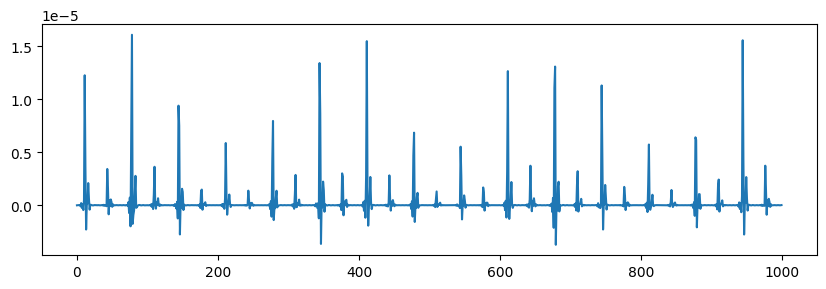

(2,)


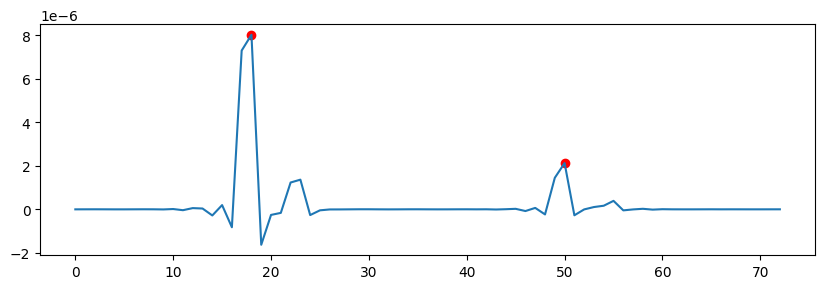

In [221]:
signal = scg_simulate(
    num_rows=1,
    sampling_rate=100,
    duration=10,
    pulse_type = "sym",
    noise_type = ["resonance"]
#     respiratory_rate=(15,16),
#     heart_rate=(70,71),
#     systolic=(100,101),
#     diastolic=(80,81)
)[:1000]
plt.plot(signal)
plt.show()

template1 = get_template(signal)
peaks = get_template_peaks(template1)
print(peaks.shape)
plt.plot(template1)
plt.scatter(peaks,template1[peaks],c="red")
plt.show()

(1006,)


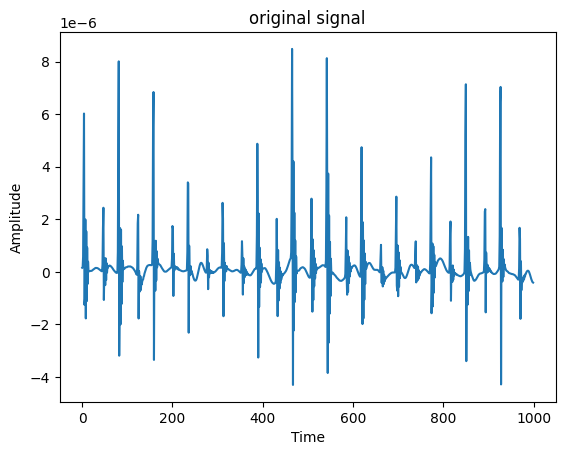

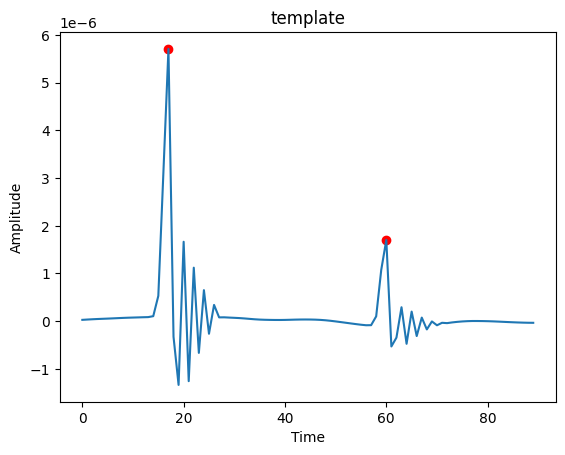

Location of Peak S:	 ( 17 , 5.7086185185878725e-06 )
Location of Peak D:	 ( 60 , 1.704483789945276e-06 )
True S:	 93.24263038548752
Calculated S:	 94.0
True D:	 79.62154226492426
Calculated D:	 91.0


In [104]:
print(signal.shape)
plt.plot(signal[:1000])
plt.title("original signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

template1 = get_template(signal[:1000])
peaks = get_template_peaks(template1)
plt.plot(template1)
plt.scatter(peaks,template1[peaks],c="red")
plt.title("template")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


print("Location of Peak S:\t","(",peaks[0],",",template1[peaks[0]],")")
print("Location of Peak D:\t","(",peaks[1],",",template1[peaks[1]],")")
print("True S:\t",220 - 100 / (1000/(peaks[1]-peaks[0])/(signal[-4]/6).astype(int) - 1))
print("Calculated S:\t", signal[-2])
print("True D:\t", template1[peaks[1]] / template1[peaks[0]] / 0.3 * 80)
print("Calculated D:\t", signal[-1])

# print(template1[peaks[0]])
# print(template1[peaks[1]])

# energy, good_pieces, template2 = processs_data_individual(signal[:1000], signal[-6:])
# peaks = get_template_peaks(template2)
# plt.plot(template2)
# plt.scatter(peaks,template2[peaks],c="red")
# plt.title("template derived from Jiayu's method")
# plt.xlabel("Time")
# plt.ylabel("Amplitude")
# plt.show()
# print("D:",template2[peaks[1]] / template2[peaks[0]] / 0.3 * 80)

# d = s * 0.3 * args['diastolic'] / 80